# Analisis Sentimen Ulasan Shopee dengan Machine Learning dan AI Support

Di buat oleh : Muhammad Riyan Maulana

Notebook ini berisi pipeline lengkap: import dataset, preprocessing, EDA, modelling (TF-IDF + Logistic Regression), topic modeling (LDA), dan penyimpanan hasil.

In [1]:
# Mount Google Drive jika ingin menyimpan/akses dari Colab (opsional)
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle

print('Libraries loaded')


Libraries loaded


In [2]:
# Ganti path ke file CSV di Colab '/content/shopee_ulasan_label7.csv'
path = '/content/shopee_ulasan_label7.csv'  # jika di Colab upload file ke /content
try:
    df = pd.read_csv(path)
except Exception as e:
    print('Tidak dapat baca dari /content. Jika sedang tidak di Colab, ubah path ke file lokal.')
    # fallback: coba mount path notebook lokal (untuk environment ini)
    path_local = '/mnt/data/shopee_ulasan_label7.csv'
    df = pd.read_csv(path_local)
    path = path_local
print('Loaded', path, '->', df.shape)
df.head()


Loaded /content/shopee_ulasan_label7.csv -> (2937, 5)


,user,ulasan,rating,label,tanggal
0,Juwairiah Juwairiah,Aplikasi shopee aku kok gak bisa gunain gratis...,1,negatif,06 Maret 2021
1,Sabyan Keisha,Menyebalkan vocer penguna baru tidak bisa di p...,1,negatif,12 Maret 2021
2,Teno Tee,"Saya sebagai penjual kecewa, penarikan saldo m...",1,negatif,27 Februari 2021
3,Nana nae,Aplukasi apa sih ini disuruh buat nama uda gue...,1,negatif,03 Maret 2021
4,Nurul Hamidah,Makin kesini Shoppe makin gak jelas. Apaan kab...,1,negatif,14 Maret 2021


In [3]:
# Preprocessing sederhana
def clean_text(s):
    if pd.isna(s): return ''
    s = str(s).lower()
    s = re.sub(r'http\S+',' ',s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+',' ',s).strip()
    return s

text_col = 'ulasan' if 'ulasan' in df.columns else df.select_dtypes(include=['object']).columns[0]
label_col = 'label' if 'label' in df.columns else ('rating' if 'rating' in df.columns else df.columns[-1])
print('Text column:', text_col, 'Label column:', label_col)

df['text_clean'] = df[text_col].apply(clean_text)
df = df[df['text_clean'].str.len()>0].copy()
df[label_col] = df[label_col].astype(str).str.strip()
print('After cleaning:', df.shape)
df[[text_col, 'text_clean', label_col]].head()


Text column: ulasan Label column: label
After cleaning: (2937, 6)


,ulasan,text_clean,label
0,Aplikasi shopee aku kok gak bisa gunain gratis...,aplikasi shopee aku kok gak bisa gunain gratis...,negatif
1,Menyebalkan vocer penguna baru tidak bisa di p...,menyebalkan vocer penguna baru tidak bisa di p...,negatif
2,"Saya sebagai penjual kecewa, penarikan saldo m...",saya sebagai penjual kecewa penarikan saldo me...,negatif
3,Aplukasi apa sih ini disuruh buat nama uda gue...,aplukasi apa sih ini disuruh buat nama uda gue...,negatif
4,Makin kesini Shoppe makin gak jelas. Apaan kab...,makin kesini shoppe makin gak jelas apaan kaba...,negatif


Distribusi label:
label
positif    1895
negatif    1042
Name: count, dtype: int64


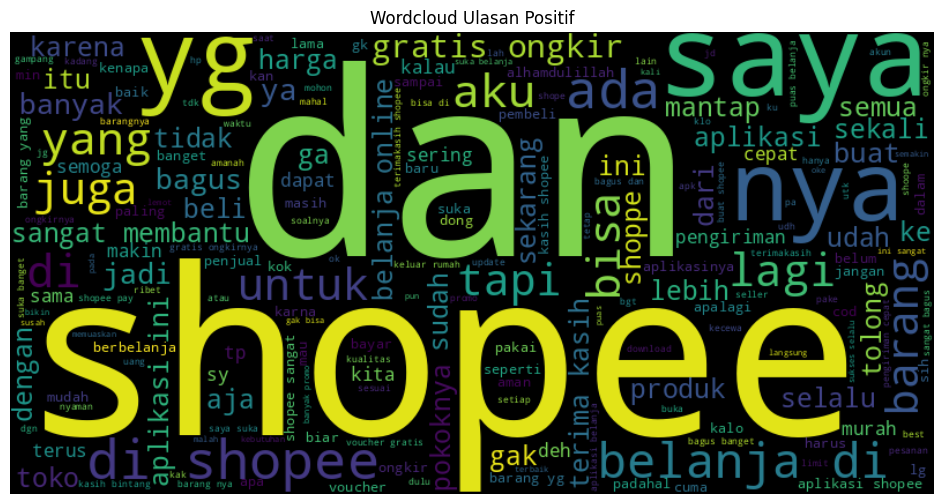

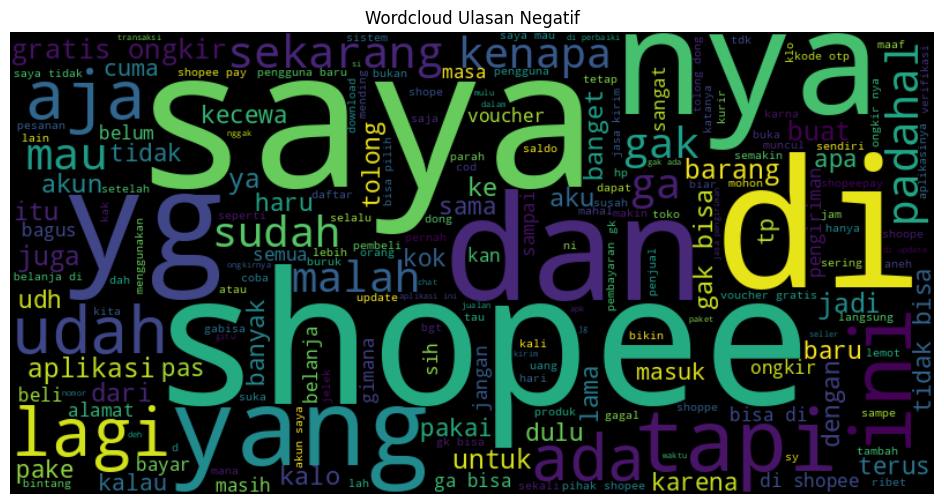

In [8]:
# EDA: distribusi label dan wordcloud
print('Distribusi label:')
print(df[label_col].value_counts())

# Wordcloud untuk ulasan positif
positive_text = ' '.join(df[df[label_col] == 'positif']['text_clean'].tolist())
if positive_text:
    wc_positive = WordCloud(width=800, height=400).generate(positive_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud Ulasan Positif')
    plt.show()
else:
    print("Tidak ada ulasan positif untuk divisualisasikan.")

# Wordcloud untuk ulasan negatif
negative_text = ' '.join(df[df[label_col] == 'negatif']['text_clean'].tolist())
if negative_text:
    wc_negative = WordCloud(width=800, height=400).generate(negative_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud Ulasan Negatif')
    plt.show()
else:
    print("Tidak ada ulasan negatif untuk divisualisasikan.")

Accuracy: 0.8350340136054422
              precision    recall  f1-score   support

     negatif       0.80      0.71      0.75       209
     positif       0.85      0.91      0.88       379

    accuracy                           0.84       588
   macro avg       0.83      0.81      0.81       588
weighted avg       0.83      0.84      0.83       588



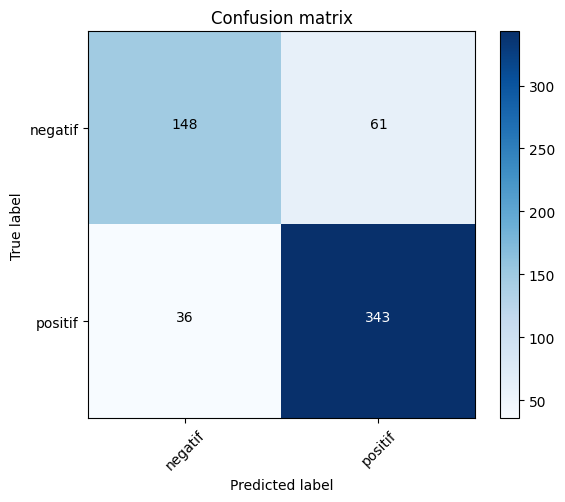

Model saved to /content/analysis_output


In [11]:
# Modelling: TF-IDF + Logistic Regression
X = df['text_clean'].values
y = df[label_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5)), ('clf', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Simpan model
outdir = '/content/analysis_output' if '/content' in path else '/mnt/data/analysis_output'
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir, 'simple_pipeline.pkl'), 'wb') as f:
    pickle.dump(pipeline, f)
print('Model saved to', outdir)

In [6]:
# Topic modelling sederhana: TF-IDF -> LDA requires CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=10, stop_words=None)
X_cv = cv.fit_transform(df['text_clean'].values)
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_cv)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = 'Topic #%d: ' % topic_idx
        message += ' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda, cv.get_feature_names_out(), 12)

# Simpan topik ke file
topics = []
for topic_idx, topic in enumerate(lda.components_):
    words = [cv.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topics.append({'topic': topic_idx, 'words': ' '.join(words)})
pd.DataFrame(topics).to_csv(os.path.join(outdir, 'lda_topics.csv'), index=False)
print('Topics saved to', outdir)


Topic #0: shopee di dan saya belanja sangat barang yang selalu dengan puas yg
Topic #1: saya di bisa shopee mau kenapa ada tapi akun padahal tidak nya
Topic #2: dan belanja shopee banyak di juga semakin gratis lagi murah lebih aplikasi
Topic #3: shopee nya aku di aplikasi banget gak ini tapi bisa makin bagus
Topic #4: di yg shopee bisa tidak saya ongkir ke ada barang cod yang
Topic #5: yg shopee ongkir gratis belanja dan sangat online untuk ada aplikasi membantu
Topics saved to /content/analysis_output


## Insight & Recommendations
- Model baseline sudah memberikan akurasi yang baik; perbaikan bisa dilakukan dengan balancing, better preprocessing, dan model yang lebih kuat.
- Gunakan LLM untuk ringkasan dan pembuatan rekomendasi otomatis dari setiap topik/cluster.
